# Load Data

In [10]:
# Load in the python script containing the same code as the load the data notebook
%run loadData.py
# now we can access train, dev, and test
# along with trainSents, devSents testSents

# Demo Data

In [11]:
trainSents[0][2]

u'Phonograph records are generally described by their diameter in inches (12", 10", 7"), the rotational speed in rpm at which they are played (16 2\u20443, 33 1\u20443, 45, 78), and their time capacity resulting from a combination of those parameters (LP \u2013 long playing 33 1\u20443 rpm, SP \u2013 78 rpm single, EP \u2013 12-inch single or extended play, 33 or 45 rpm); their reproductive quality or level of fidelity (high-fidelity, orthophonic, full-range, etc.), and the number of audio channels provided (mono, stereo, quad, etc.).'

In [12]:
train[0][0]

{u'answer': u'long playing',
 u'answer_sentence': 2,
 u'question': u'What does LP stand for when it comes to time capacity?'}

In [13]:
documents = trainSents[0]
questions = train[0]

# Useful Imports

In [14]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Sentence Retrieval Pool Boosting

## Issue

- Candidate sentence not appearing in sentence retrieval pool

## Goal

- Increase the chance that answer appears in retrieval selection pool (either single sentence or vector of sentences).

## Possible Strategies

- Increase Size of Pool
- Rank Sentences in retrieved Pool
- Increase Size of Trained Models (nltk.corpus)
- Use in combination with Trained Semantic Models (pretrained word2vec/doc2vec)
- Tune preprocessing and hyperparameters to increase pool quality
- Determine quality effects of models on a per corpus, multi-corpus or per doc basis

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [77]:
# Tuning functions

import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Follow lemmatize function from guide notebook: WSTA_N1B_preprocessing.ipynb
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

word_tokenizer = nltk.tokenize.WordPunctTokenizer() #word_tokenize #tokenize.regexp.WordPunctTokenizer()

def pre_process(line):
    tokenized_sentence = word_tokenizer.tokenize(line.lower())
    lemmatized_sentence = [lemmatize(token) for token in tokenized_sentence]
    return lemmatized_sentence

In [78]:
# Core functions

def vectorize_documents(text_documents):

    vectorizer = TfidfVectorizer(stop_words='english', tokenizer=pre_process)
    vector_documents = vectorizer.fit_transform(text_documents)
    
    return [vector_documents, vectorizer]

def vectorize_query(vectorizer, text_query):
    return vectorizer.transform([text_query])

def process_neighbours(vector_documents):
    
    neighbours = NearestNeighbors(1, algorithm="brute", metric="cosine")
    neighbours.fit(vector_documents)
    
    return neighbours

def closest_documents(neighbours, vector_query, n):

    result = neighbours.kneighbors(vector_query, n, return_distance=True)

    result_indices = result[1][0]
    result_distances = result[0][0]
    
    return sorted(zip(result_indices, result_distances), key=lambda x: x[1])

In [5]:
def raw_text_to_sentences(raw_text, tokenizer):
    return tokenizer.tokenize(raw_text)  

In [29]:
def processed_sentence(sentence):
    words = sentence.split()
    return " ".join(words)

## Increase Size of Trained Models

In [30]:
full_sent_corpus = []

In [31]:
punkt_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
corpora = [nltk.corpus.reuters]

### nltk.corpus

In [32]:
for corpus in corpora:
    
    for i, fileid in enumerate(corpus.fileids()):
        
        doc = nltk.corpus.reuters.raw(fileid)
        sentences = raw_text_to_sentences(doc, punkt_tokenizer)
        
        for j, sentence in enumerate(sentences):
            
            proc_sent = processed_sentence(sentences[0])
            
            if i == 0 and j == 0:
                
                print "Raw:\n"
                print repr(sentence), "\n"
                print "Processed:\n"
                print repr(proc_sent)
                
            full_sent_corpus.append(proc_sent)

### Training set

In [33]:
for i, doc in enumerate(trainSents):
    for j, raw_sent in enumerate(doc):
        
        if i == 0 and j == 0:
            print raw_sent
            
        full_sent_corpus.append(raw_sent)

A gramophone record (phonograph record in American English) or vinyl record, commonly known as a "record", is an analogue sound storage medium in the form of a flat polyvinyl chloride (previously shellac) disc with an inscribed, modulated spiral groove.


In [34]:
full_vector_documents, full_vectorizer = vectorize_documents(full_sent_corpus)

## Increase Size of Pool, vectorize candidate sentence retrieval

In [79]:
# Demonstration function
def demo_process_set_vector(questions, documents):
    
#     vector_documents = full_vectorizer.transform(documents)
    vector_documents, vectorizer = vectorize_documents(documents)
    
#     analyze = full_vectorizer.build_analyzer()
    analyze = vectorizer.build_analyzer()
    
    neighbours = process_neighbours(vector_documents)

    print "=" * 20
    print "Vector documents shape: {0}".format(vector_documents.shape)
    print "Actual documents length: {0}".format(len(documents))
    print "=" * 20, "\n"
    
    for question in questions[10:10+3]:
        
        text_query = question["question"]

        print "Text query:\n\n\t{0}\n".format(text_query)

#         vector_query = vectorize_query(full_vectorizer, text_query)
        vector_query = vectorize_query(vectorizer, text_query)

        print "Vector query shape:\n\n\t{0}".format(vector_query.shape)
      
        results = closest_documents(neighbours, vector_query, 1)
        
        print "Query (text):\n\n\t{0}\n".format(text_query)            
        print "Query (vector text):\n"
        pp.pprint(analyze(text_query))       
        
        print "Answer Sentence (text):\n\n\t{0}\n".format(text_query)            
        print "Answer Sentence (vector text):\n"
        pp.pprint(analyze(text_query))               
        
        
        for result_index, result_distance in results:
        
            print
            print "Result:\n\n\tDistance ({0}), Index ({1})\n".format(result_distance, result_index)
            print
            print "Document (text):\n\n\t{0}".format(documents[result_index].encode("utf-8"))
            print
            print "Document (vector text): \n\n"
            pp.pprint(analyze(documents[result_index]))

            print "\n", "=" * 20, "\n"
        
        break

In [80]:
demo_process_set_vector(questions, documents)

Vector documents shape: (463, 2047)
Actual documents length: 463

Text query:

	What was the original intent of the phonautograph?

Vector query shape:

	(1, 2047)
Query (text):

	What was the original intent of the phonautograph?

Query (vector text):

[u'original', u'intent', u'phonautograph', u'?']
Answer Sentence (text):

	What was the original intent of the phonautograph?

Answer Sentence (vector text):

[u'original', u'intent', u'phonautograph', u'?']

Result:

	Distance (0.71736934448), Index (9)


Document (text):

	The phonautograph, patented by Léon Scott in 1857, used a vibrating diaphragm and stylus to graphically record sound waves as tracings on sheets of paper, purely for visual analysis and without any intent of playing them back.

Document (vector text): 


[   u'phonautograph',
    u',',
    u'patent',
    u'l\xe9on',
    u'scott',
    u'1857',
    u',',
    u'use',
    u'vibrate',
    u'diaphragm',
    u'stylus',
    u'graphically',
    u'record',
    u'sound',
    u

In [81]:
def evaluateSentenceRetrivalVector(questionsList, documentsList, numToEval, sentenceVectorSize):
    
    numCorrect = 0
    numWrong = 0
    
    for i in range (0, numToEval):
        
        documents = documentsList[i]
        questions = questionsList[i]
        
#         vector_documents = full_vectorizer.transform(documents)
        vector_documents, vectorizer = vectorize_documents(documents)

#         analyze = full_vectorizer.build_analyzer()
        analyze = vectorizer.build_analyzer()
        
        neighbours = process_neighbours(vector_documents)        
        
        for j in range (0, len(questions)):
            
            text_query = questions[j]["question"]
            
#             vector_query = vectorize_query(full_vectorizer, text_query)
            vector_query = vectorize_query(vectorizer, text_query)
            
            results  = closest_documents(neighbours, vector_query, sentenceVectorSize)
            
            hit = False
            
            for result_index, result_distance in results:
                if result_index == int(questions[j]["answer_sentence"]):
                    numCorrect += 1
                    hit = True
                    break
            
            if not hit:
                numWrong += 1
                
    return (numCorrect, numWrong)

In [82]:
results = []

for x in [1,2,3,4,5,10,20,30]:
    
    (correct, wrong) = evaluateSentenceRetrivalVector(train, trainSents, 10, x)
    
    print
    print("Sentence Vector Size : " + str(x))
    print("\tNumber Correct : " + str(correct))
    print("\tNumber incorrect: " + str(wrong))
    print("\tTotal : " + str(correct + wrong))
    print ("\tAverage correct : " + str((correct + 0.0) / (correct + wrong)))
    
    results.append((x, (correct + 0.0) / (correct + wrong)))


Sentence Vector Size : 1
	Number Correct : 928
	Number incorrect: 733
	Total : 1661
	Average correct : 0.558699578567

Sentence Vector Size : 2
	Number Correct : 1129
	Number incorrect: 532
	Total : 1661
	Average correct : 0.679711017459

Sentence Vector Size : 3
	Number Correct : 1216
	Number incorrect: 445
	Total : 1661
	Average correct : 0.73208910295

Sentence Vector Size : 4
	Number Correct : 1264
	Number incorrect: 397
	Total : 1661
	Average correct : 0.760987357014

Sentence Vector Size : 5
	Number Correct : 1318
	Number incorrect: 343
	Total : 1661
	Average correct : 0.793497892836

Sentence Vector Size : 10
	Number Correct : 1428
	Number incorrect: 233
	Total : 1661
	Average correct : 0.859723058399

Sentence Vector Size : 20
	Number Correct : 1501
	Number incorrect: 160
	Total : 1661
	Average correct : 0.903672486454

Sentence Vector Size : 30
	Number Correct : 1531
	Number incorrect: 130
	Total : 1661
	Average correct : 0.921733895244


## Plotting Vector Results

In [26]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

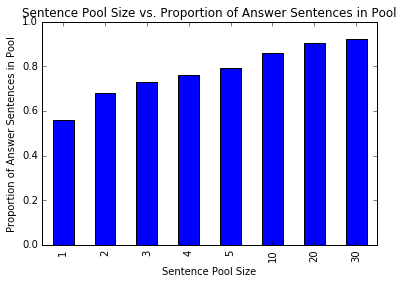

In [27]:
ax = pd.DataFrame(results).plot.bar(x=0, y=1, title="Sentence Pool Size vs. Proportion of Answer Sentences in Pool", legend=False)

ax.set_xlabel("Sentence Pool Size")
ax.set_ylabel("Proportion of Answer Sentences in Pool")

In [50]:
print "Average number of sentences per document:", sum(map(len, trainSents)) * 1.0 / len(trainSents)

Average number of sentences per document: 208.819444444


# Additional Models

## Pretrained word2vec

In [95]:
# From: WSTA_N10_word_vectors

import gensim
from nltk.data import find

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False) # Use this if newer gensim: gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [129]:
# By word
print word2vec_model.similarity("king", "queen")

# By set of words
print word2vec_model.n_similarity(["king", "royal"], ["queen", "royal"])

# Word vector from word
print word2vec_model["turtle"]
    
# Similarity measures
print word2vec_model.most_similar(positive=["king"], negative=["queen"], topn=10)
print word2vec_model.most_similar_cosmul(positive=["king"], negative=["queen"], topn=10)

print word2vec_model.doesnt_match(["farm", "turtle", "kangaroo"])
print word2vec_model.similarity("king", "queen")

0.651095837676
0.887075321449
[ 0.01637     0.072989   -0.066381    0.0633773  -0.0256813  -0.0699854
 -0.0210256  -0.0164451   0.031989    0.0140421   0.0367949  -0.0961173
 -0.0162949  -0.138769   -0.0955165  -0.0447546  -0.0459561  -0.0408498
 -0.13816901 -0.00071806  0.0405495  -0.019674    0.0361942   0.0949158
 -0.0447546  -0.0651795  -0.0294359   0.0762931   0.139971   -0.0100623
 -0.0252308   0.054066   -0.045055   -0.00867308  0.0262821  -0.0567693
  0.0684835  -0.0162949   0.00702106  0.0444542  -0.0238791   0.0456557
  0.0726887   0.0804982  -0.0211758  -0.108132   -0.00253434  0.0859048
  0.18863     0.0582711  -0.0195238   0.0657802   0.0768938  -0.0318388
  0.0138169   0.0367949   0.0333407   0.0204249   0.151985    0.00435531
 -0.009837   -0.0294359  -0.0049185  -0.0396484   0.0309377  -0.0657802
  0.0008307  -0.0414506  -0.0130659  -0.00403617  0.0387473   0.0252308
 -0.0049185  -0.0420513  -0.039348   -0.00998718 -0.0156191  -0.0810989
 -0.0597729  -0.0241795  -0.03273

## Intersected doc2vec

In [108]:
import logging
import gensim
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [98]:
# Hyperparameter tuning example

sampling_threshold = 1e-5
hs = 0
dm = 0
negative_size = 5
dbow_words = 1

vector_size = 300
window_size = 15
min_count = 10

train_epoch = 30

alpha = 0.025
min_alpha = 0.0001

alpha_delta = (alpha - min_alpha) / train_epoch

worker_count = 6

In [99]:
sentences = []

for doc in trainSents:
    for sent in doc:
        sentences.append(sent.lower().split())

In [100]:
from random import shuffle

In [101]:
class LabeledLineSentence(object):
    def __iter__(self):        
        for i, sent in enumerate(sentences):
              yield gensim.models.doc2vec.LabeledSentence(sent, [i])

In [102]:
sent_corp = LabeledLineSentence()

In [103]:
shuffle(sentences)
doc2vec_model = gensim.models.Doc2Vec(
    size=vector_size, 
    window=window_size, 
    min_count=min_count, 
    sample=sampling_threshold, 
    workers=worker_count,
    hs=hs, dm=dm,
    negative=negative_size,
    dbow_words=dbow_words,
    alpha=alpha, 
    min_alpha=min_alpha)

In [104]:
doc2vec_model.build_vocab(sent_corp)


In [105]:
doc2vec_model.intersect_word2vec_format(word2vec_sample, binary=False)

In [111]:
for epoch in range(train_epoch):

    shuffle(sentences)
    
    print "Round: ", epoch

    doc2vec_model.alpha = alpha
    doc2vec_model.min_alpha = alpha

    doc2vec_model.train(sent_corp)

    alpha -= alpha_delta

Round:  0
Round:  1
Round:  2
Round:  3
Round:  4
Round:  5
Round:  6
Round:  7
Round:  8
Round:  9
Round:  10
Round:  11
Round:  12
Round:  13
Round:  14
Round:  15
Round:  16
Round:  17
Round:  18
Round:  19
Round:  20
Round:  21
Round:  22
Round:  23
Round:  24
Round:  25
Round:  26
Round:  27
Round:  28
Round:  29


In [130]:
# Save vec
doc2vec_model.save("./doc2vec_model.bin")

In [131]:
# Access vector by sen index
print doc2vec_model.docvecs[0]

# Similarity measures
print doc2vec_model.doesnt_match(["farm", "turtle", "kangaroo"])
print doc2vec_model.most_similar(positive=["king"], negative=["queen"], topn=10)
print doc2vec_model.most_similar_cosmul(positive=["king"], negative=["queen"], topn=10)
print doc2vec_model.n_similarity(["king"], ["queen"])
print doc2vec_model.similarity("king", "queen")

# Infer vector of new sentence
infer_vec = doc2vec_model.infer_vector(["king", "queen"])

print infer_vec

[  1.31497025e-01   4.28963780e-01   1.89759552e-01  -7.62067363e-03
   2.36616462e-01  -5.26692905e-02   1.90043628e-01  -3.95169616e-01
   3.86164904e-01  -8.74810666e-02  -6.36034310e-02  -3.79510403e-01
  -9.33280364e-02   3.44261453e-02  -1.69033721e-01  -2.06876159e-01
   1.68516830e-01   1.85036257e-01   1.94571361e-01   7.64003256e-03
   1.67728320e-01   2.91753829e-01  -2.83090323e-01   1.77406911e-02
   2.58673459e-01  -1.62149072e-02  -1.00098200e-01  -7.95970857e-02
   3.50048244e-01  -3.74841362e-01  -4.44957241e-03   8.59596208e-02
  -7.26464093e-02   4.30337004e-02  -1.07183091e-01  -3.78531665e-01
   2.62540698e-01  -5.18812798e-02   4.85228328e-03   5.47052249e-02
  -8.39148313e-02   1.10118851e-01   2.24901006e-01  -2.22072646e-01
  -2.20796570e-01  -2.63728440e-01  -9.82312933e-02   1.03392914e-01
   1.51837245e-01  -2.79694200e-01  -4.59061339e-02  -7.51143396e-02
  -1.55862719e-01   4.17556502e-02  -2.17629701e-01  -1.29511699e-01
   1.22726662e-02  -2.05150083e-01